<a href="https://colab.research.google.com/github/machiwao/pjdsc-optima-prime-sakayan-express/blob/main/SakayanExpress_RouteSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sakayan Express - Route Simulation
Simulate bus routes in historical data. Produce a predictive route simulation based on historical data by suggesting recommended number of buses

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [249]:
# Possible Pseudocode
'''# Simulate roundtrips and deployment of buses
def bus_route_simulation(num_buses, terminals, stops, model):
    buses = initialize_buses(num_buses, terminals)

    while simulation_running:
        for bus in buses:
            if bus.at_terminal():
                # Get the predicted demand for the next trip (northbound or southbound)
                demand = model.predict(bus.next_route())

                # Deploy bus based on predicted demand
                deploy_bus(bus, demand)

            # Move the bus along the route
            bus.move_to_next_stop()

            # Pick up passengers based on prediction
            predicted_waiting = model.predict(bus.current_stop())
            bus.pick_up_passengers(predicted_waiting)

            # Update waiting passengers
            update_waiting_passengers(bus.current_stop(), predicted_waiting)

        # End condition: All buses have completed the simulation
        if all_buses_completed(buses):
            break

# Run the simulation
bus_route_simulation(num_buses=10, terminals=[Cluster0, Cluster18], stops=all_stops, model=rf_model)
'''

'# Simulate roundtrips and deployment of buses\ndef bus_route_simulation(num_buses, terminals, stops, model):\n    buses = initialize_buses(num_buses, terminals)\n\n    while simulation_running:\n        for bus in buses:\n            if bus.at_terminal():\n                # Get the predicted demand for the next trip (northbound or southbound)\n                demand = model.predict(bus.next_route())\n\n                # Deploy bus based on predicted demand\n                deploy_bus(bus, demand)\n\n            # Move the bus along the route\n            bus.move_to_next_stop()\n\n            # Pick up passengers based on prediction\n            predicted_waiting = model.predict(bus.current_stop())\n            bus.pick_up_passengers(predicted_waiting)\n\n            # Update waiting passengers\n            update_waiting_passengers(bus.current_stop(), predicted_waiting)\n\n        # End condition: All buses have completed the simulation\n        if all_buses_completed(buses):\n      

In [250]:
'''import pandas as pd
import folium
from geopy.distance import geodesic
import random
import time

# Assume data is a pandas DataFrame with columns: ['timestamp', 'latitude', 'longitude', 'stop_id', 'waiting_passengers']
# Bus data includes columns: ['bus_id', 'current_stop', 'latitude', 'longitude', 'capacity', 'current_passengers', 'is_active']

# Example data for buses and bus stops (replace with actual data)
bus_stops = pd.DataFrame({
    'stop_id': [1, 2, 3, 4, 5],
    'latitude': [14.550112, 14.535923, 14.524773, 14.507963, 14.507970],
    'longitude': [121.045, 121.065, 121.060, 121.045, 121.045],
    'waiting_passengers': [5, 10, 8, 15, 20],  # Number of passengers waiting at each stop
})

buses = pd.DataFrame({
    'bus_id': [1, 2, 3],
    'current_stop': [1, 2, 3],
    'latitude': [14.550112, 14.535923, 14.524773],
    'longitude': [121.045, 121.065, 121.060],
    'capacity': [50, 50, 50],
    'current_passengers': [30, 40, 35],  # Starting number of passengers
    'is_active': [True, True, True],  # Whether the bus is in service
})

# Simulation settings
bus_capacity_threshold = 0.8  # 80% capacity threshold
fleet_utilization_threshold = 0.75  # 75% of the fleet should be active
time_step = 5  # Time step in minutes for each simulation step

# Function to calculate the number of passengers boarding
def board_passengers(bus, stop):
    passengers_waiting = stop['waiting_passengers']
    available_seats = bus['capacity'] - bus['current_passengers']
    passengers_boarding = min(available_seats, passengers_waiting)

    # Update bus and stop information
    bus['current_passengers'] += passengers_boarding
    stop['waiting_passengers'] -= passengers_boarding
    return passengers_boarding

# Function to simulate bus movement and interactions at stops
def simulate_bus_movement(buses, bus_stops):
    for _, bus in buses.iterrows():
        if not bus['is_active']:
            continue

        # Move bus to the next stop (simple circular route logic)
        next_stop_id = (bus['current_stop'] % len(bus_stops)) + 1
        next_stop = bus_stops.loc[bus_stops['stop_id'] == next_stop_id].iloc[0]

        # Calculate distance to the next stop (can be used for timing and progress)
        distance_to_next_stop = geodesic(
            (bus['latitude'], bus['longitude']),
            (next_stop['latitude'], next_stop['longitude'])
        ).meters

        # Simulate boarding and alighting at the next stop
        if bus['current_passengers'] < bus['capacity'] * bus_capacity_threshold:
            passengers_boarded = board_passengers(bus, next_stop)
            print(f"Bus {bus['bus_id']} boarded {passengers_boarded} passengers at Stop {next_stop['stop_id']}.")
        else:
            print(f"Bus {bus['bus_id']} is over 80% capacity. Passengers are not allowed to board.")

        # Simulate alighting (random number for now)
        passengers_alighting = random.randint(0, bus['current_passengers'] // 3)
        bus['current_passengers'] -= passengers_alighting
        print(f"Bus {bus['bus_id']} alighted {passengers_alighting} passengers at Stop {next_stop['stop_id']}.")

        # Update bus position to the next stop
        buses.loc[buses['bus_id'] == bus['bus_id'], 'current_stop'] = next_stop_id
        buses.loc[buses['bus_id'] == bus['bus_id'], 'latitude'] = next_stop['latitude']
        buses.loc[buses['bus_id'] == bus['bus_id'], 'longitude'] = next_stop['longitude']

# Function to check fleet utilization
def check_fleet_utilization(buses):
    active_buses = buses[buses['is_active'] == True]
    utilization = len(active_buses) / len(buses)
    if utilization < fleet_utilization_threshold:
        print(f"Fleet utilization is below {fleet_utilization_threshold * 100}%, deploying more buses...")
        # Simulate deploying more buses (activate additional buses)
        for bus_id in buses[buses['is_active'] == False].head(1)['bus_id']:
            buses.loc[buses['bus_id'] == bus_id, 'is_active'] = True
    else:
        print(f"Fleet utilization: {utilization * 100:.2f}%")

# Visualization using Folium (to show current state)
def visualize_route(buses, bus_stops):
    m = folium.Map(location=[14.550112, 121.045], zoom_start=13)

    # Add bus stop markers
    for _, stop in bus_stops.iterrows():
        folium.Marker(
            location=[stop['latitude'], stop['longitude']],
            popup=f"Stop {stop['stop_id']} with {stop['waiting_passengers']} passengers waiting",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

    # Add bus markers
    for _, bus in buses.iterrows():
        color = 'red' if bus['current_passengers'] > bus['capacity'] * bus_capacity_threshold else 'green'
        folium.Marker(
            location=[bus['latitude'], bus['longitude']],
            popup=f"Bus {bus['bus_id']} with {bus['current_passengers']} passengers",
            icon=folium.Icon(color=color, icon='bus')
        ).add_to(m)

    # Save the map as an HTML file
    m.save('bus_route_simulation.html')
    print("Route simulation map saved as bus_route_simulation.html")

# Main simulation loop
for t in range(10):  # Simulate 10 time steps
    print(f"Simulation Step {t + 1}")

    # Simulate bus movement and boarding/alighting
    simulate_bus_movement(buses, bus_stops)

    # Check fleet utilization
    check_fleet_utilization(buses)

    # Visualize the current state
    visualize_route(buses, bus_stops)

    # Wait for the next time step (can be replaced with real-time intervals)
    time.sleep(2)
'''

'import pandas as pd\nimport folium\nfrom geopy.distance import geodesic\nimport random\nimport time\n\n# Assume data is a pandas DataFrame with columns: [\'timestamp\', \'latitude\', \'longitude\', \'stop_id\', \'waiting_passengers\']\n# Bus data includes columns: [\'bus_id\', \'current_stop\', \'latitude\', \'longitude\', \'capacity\', \'current_passengers\', \'is_active\']\n\n# Example data for buses and bus stops (replace with actual data)\nbus_stops = pd.DataFrame({\n    \'stop_id\': [1, 2, 3, 4, 5],\n    \'latitude\': [14.550112, 14.535923, 14.524773, 14.507963, 14.507970],\n    \'longitude\': [121.045, 121.065, 121.060, 121.045, 121.045],\n    \'waiting_passengers\': [5, 10, 8, 15, 20],  # Number of passengers waiting at each stop\n})\n\nbuses = pd.DataFrame({\n    \'bus_id\': [1, 2, 3],\n    \'current_stop\': [1, 2, 3],\n    \'latitude\': [14.550112, 14.535923, 14.524773],\n    \'longitude\': [121.045, 121.065, 121.060],\n    \'capacity\': [50, 50, 50],\n    \'current_passenger

In [251]:
'''import pandas as pd
import numpy as np
import folium
import random
import time

# Assume the model has been trained already and saved as a pickle file
import joblib
model = joblib.load('waiting_passengers_model.pkl')  # Load your trained model

# Example function to predict waiting passengers using the trained model
def predict_waiting_passengers(hour, direction, minute, second, day_of_week, longitude, latitude, nearest_bus_stop):
    features = {
        'Hour': [hour],
        'direction': [direction],
        'Min': [minute],
        'Sec': [second],
        'Day_of_week': [day_of_week],
        'longitude': [longitude],
        'latitude': [latitude],
        'nearest_bus_stop': [nearest_bus_stop]
    }
    df = pd.DataFrame(features)
    return int(model.predict(df)[0])  # Predict and return as an integer

# Example data for bus stops and buses (replace with actual data)
bus_stops = pd.DataFrame({
    'stop_id': [1, 2, 3, 4, 5],
    'latitude': [14.550112, 14.535923, 14.524773, 14.507963, 14.507970],
    'longitude': [121.045, 121.065, 121.060, 121.045, 121.045],
    'nearest_bus_stop': ['Stop1', 'Stop2', 'Stop3', 'Stop4', 'Stop5'],  # Nearest bus stop feature
    'waiting_passengers': [0, 0, 0, 0, 0]  # Initially 0, will be updated by the model
})

buses = pd.DataFrame({
    'bus_id': [1, 2, 3],
    'current_stop': [1, 2, 3],
    'latitude': [14.550112, 14.535923, 14.524773],
    'longitude': [121.045, 121.065, 121.060],
    'capacity': [50, 50, 50],
    'current_passengers': [30, 40, 35],  # Starting number of passengers
    'is_active': [True, True, True],  # Whether the bus is in service
})

# Function to predict waiting passengers for all stops
def update_waiting_passengers(bus_stops, current_time):
    """
    Update the number of waiting passengers at each stop using the prediction model.
    current_time: (hour, minute, second, day_of_week)
    """
    hour, minute, second, day_of_week = current_time
    direction = random.choice(['northbound', 'southbound'])  # Example direction

    for i, stop in bus_stops.iterrows():
        # Predict the number of waiting passengers at this stop
        predicted_waiting = predict_waiting_passengers(
            hour=hour,
            direction=direction,
            minute=minute,
            second=second,
            day_of_week=day_of_week,
            longitude=stop['longitude'],
            latitude=stop['latitude'],
            nearest_bus_stop=stop['nearest_bus_stop']
        )
        # Update the DataFrame with predicted values
        bus_stops.at[i, 'waiting_passengers'] = predicted_waiting
'''

'import pandas as pd\nimport numpy as np\nimport folium\nimport random\nimport time\n\n# Assume the model has been trained already and saved as a pickle file\nimport joblib\nmodel = joblib.load(\'waiting_passengers_model.pkl\')  # Load your trained model\n\n# Example function to predict waiting passengers using the trained model\ndef predict_waiting_passengers(hour, direction, minute, second, day_of_week, longitude, latitude, nearest_bus_stop):\n    features = {\n        \'Hour\': [hour],\n        \'direction\': [direction],\n        \'Min\': [minute],\n        \'Sec\': [second],\n        \'Day_of_week\': [day_of_week],\n        \'longitude\': [longitude],\n        \'latitude\': [latitude],\n        \'nearest_bus_stop\': [nearest_bus_stop]\n    }\n    df = pd.DataFrame(features)\n    return int(model.predict(df)[0])  # Predict and return as an integer\n\n# Example data for bus stops and buses (replace with actual data)\nbus_stops = pd.DataFrame({\n    \'stop_id\': [1, 2, 3, 4, 5],\n   

In [252]:
'''# Function to simulate bus movement and interactions at stops
def simulate_bus_movement(buses, bus_stops, current_time):
    for _, bus in buses.iterrows():
        if not bus['is_active']:
            continue

        # Move bus to the next stop (simple circular route logic)
        next_stop_id = (bus['current_stop'] % len(bus_stops)) + 1
        next_stop = bus_stops.loc[bus_stops['stop_id'] == next_stop_id].iloc[0]

        # Simulate boarding using the predicted waiting passengers
        if bus['current_passengers'] < bus['capacity'] * 0.8:
            passengers_waiting = next_stop['waiting_passengers']
            available_seats = bus['capacity'] - bus['current_passengers']
            passengers_boarded = min(available_seats, passengers_waiting)

            # Update bus and stop information
            buses.loc[buses['bus_id'] == bus['bus_id'], 'current_passengers'] += passengers_boarded
            bus_stops.loc[bus_stops['stop_id'] == next_stop_id, 'waiting_passengers'] -= passengers_boarded

            print(f"Bus {bus['bus_id']} boarded {passengers_boarded} passengers at Stop {next_stop_id}.")
        else:
            print(f"Bus {bus['bus_id']} is over 80% capacity. No passengers boarded.")

        # Simulate alighting (random number for now)
        passengers_alighting = random.randint(0, bus['current_passengers'] // 3)
        buses.loc[buses['bus_id'] == bus['bus_id'], 'current_passengers'] -= passengers_alighting
        print(f"Bus {bus['bus_id']} alighted {passengers_alighting} passengers at Stop {next_stop_id}.")

        # Update bus position to the next stop
        buses.loc[buses['bus_id'] == bus['bus_id'], 'current_stop'] = next_stop_id
        buses.loc[buses['bus_id'] == bus['bus_id'], 'latitude'] = next_stop['latitude']
        buses.loc[buses['bus_id'] == bus['bus_id'], 'longitude'] = next_stop['longitude']

# Visualization using Folium (to show current state)
def visualize_route(buses, bus_stops):
    m = folium.Map(location=[14.550112, 121.045], zoom_start=13)

    # Add bus stop markers
    for _, stop in bus_stops.iterrows():
        folium.Marker(
            location=[stop['latitude'], stop['longitude']],
            popup=f"Stop {stop['stop_id']} with {stop['waiting_passengers']} passengers waiting",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

    # Add bus markers
    for _, bus in buses.iterrows():
        color = 'red' if bus['current_passengers'] > bus['capacity'] * 0.8 else 'green'
        folium.Marker(
            location=[bus['latitude'], bus['longitude']],
            popup=f"Bus {bus['bus_id']} with {bus['current_passengers']} passengers",
            icon=folium.Icon(color=color, icon='bus')
        ).add_to(m)

    # Save the map as an HTML file
    m.save('bus_route_simulation.html')
    print("Route simulation map saved as bus_route_simulation.html")

# Main simulation loop
for t in range(10):  # Simulate 10 time steps
    current_time = (8, t * 5 % 60, 0, 1)  # Example time: Hour 8, step every 5 minutes, Monday
    print(f"Simulation Step {t + 1}")

    # Update waiting passengers using the AI model
    update_waiting_passengers(bus_stops, current_time)

    # Simulate bus movement and boarding/alighting
    simulate_bus_movement(buses, bus_stops, current_time)

    # Visualize the current state
    visualize_route(buses, bus_stops)

    # Wait for the next time step (can be replaced with real-time intervals)
    time.sleep(2)
'''

'# Function to simulate bus movement and interactions at stops\ndef simulate_bus_movement(buses, bus_stops, current_time):\n    for _, bus in buses.iterrows():\n        if not bus[\'is_active\']:\n            continue\n\n        # Move bus to the next stop (simple circular route logic)\n        next_stop_id = (bus[\'current_stop\'] % len(bus_stops)) + 1\n        next_stop = bus_stops.loc[bus_stops[\'stop_id\'] == next_stop_id].iloc[0]\n\n        # Simulate boarding using the predicted waiting passengers\n        if bus[\'current_passengers\'] < bus[\'capacity\'] * 0.8:\n            passengers_waiting = next_stop[\'waiting_passengers\']\n            available_seats = bus[\'capacity\'] - bus[\'current_passengers\']\n            passengers_boarded = min(available_seats, passengers_waiting)\n\n            # Update bus and stop information\n            buses.loc[buses[\'bus_id\'] == bus[\'bus_id\'], \'current_passengers\'] += passengers_boarded\n            bus_stops.loc[bus_stops[\'stop_id

In [253]:
'''import joblib

# Load the pre-trained model for alighting prediction
alighting_model = joblib.load('alighting_passengers_model.pkl')  # Load your trained model

# Example function to predict alighting passengers using the trained model
def predict_alighting_passengers(hour, direction, stop_id, current_passengers, day_of_week):
    features = {
        'Hour': [hour],
        'direction': [direction],
        'stop_id': [stop_id],
        'current_passengers': [current_passengers],
        'Day_of_week': [day_of_week]
    }
    df = pd.DataFrame(features)
    return int(alighting_model.predict(df)[0])  # Predict and return as an integer
'''

"import joblib\n\n# Load the pre-trained model for alighting prediction\nalighting_model = joblib.load('alighting_passengers_model.pkl')  # Load your trained model\n\n# Example function to predict alighting passengers using the trained model\ndef predict_alighting_passengers(hour, direction, stop_id, current_passengers, day_of_week):\n    features = {\n        'Hour': [hour],\n        'direction': [direction],\n        'stop_id': [stop_id],\n        'current_passengers': [current_passengers],\n        'Day_of_week': [day_of_week]\n    }\n    df = pd.DataFrame(features)\n    return int(alighting_model.predict(df)[0])  # Predict and return as an integer\n"

In [254]:
'''# Function to simulate bus movement and interactions at stops
def simulate_bus_movement(buses, bus_stops, current_time):
    for _, bus in buses.iterrows():
        if not bus['is_active']:
            continue

        # Move bus to the next stop (simple circular route logic)
        next_stop_id = (bus['current_stop'] % len(bus_stops)) + 1
        next_stop = bus_stops.loc[bus_stops['stop_id'] == next_stop_id].iloc[0]

        # Simulate boarding using the predicted waiting passengers
        if bus['current_passengers'] < bus['capacity'] * 0.8:
            passengers_waiting = next_stop['waiting_passengers']
            available_seats = bus['capacity'] - bus['current_passengers']
            passengers_boarded = min(available_seats, passengers_waiting)

            # Update bus and stop information
            buses.loc[buses['bus_id'] == bus['bus_id'], 'current_passengers'] += passengers_boarded
            bus_stops.loc[bus_stops['stop_id'] == next_stop_id, 'waiting_passengers'] -= passengers_boarded

            print(f"Bus {bus['bus_id']} boarded {passengers_boarded} passengers at Stop {next_stop_id}.")
        else:
            print(f"Bus {bus['bus_id']} is over 80% capacity. No passengers boarded.")

        # Replace random alighting with model-predicted alighting
        hour, minute, second, day_of_week = current_time
        direction = random.choice(['northbound', 'southbound'])  # Example direction
        current_passengers = bus['current_passengers']

        # Predict the number of passengers alighting at the current stop
        passengers_alighting = predict_alighting_passengers(
            hour=hour,
            direction=direction,
            stop_id=next_stop_id,
            current_passengers=current_passengers,
            day_of_week=day_of_week
        )

        # Ensure that the number of passengers alighting does not exceed current passengers on the bus
        passengers_alighting = min(passengers_alighting, current_passengers)

        # Update the bus' current passengers after alighting
        buses.loc[buses['bus_id'] == bus['bus_id'], 'current_passengers'] -= passengers_alighting
        print(f"Bus {bus['bus_id']} alighted {passengers_alighting} passengers at Stop {next_stop_id}.")

        # Update bus position to the next stop
        buses.loc[buses['bus_id'] == bus['bus_id'], 'current_stop'] = next_stop_id
        buses.loc[buses['bus_id'] == bus['bus_id'], 'latitude'] = next_stop['latitude']
        buses.loc[buses['bus_id'] == bus['bus_id'], 'longitude'] = next_stop['longitude']
'''

'# Function to simulate bus movement and interactions at stops\ndef simulate_bus_movement(buses, bus_stops, current_time):\n    for _, bus in buses.iterrows():\n        if not bus[\'is_active\']:\n            continue\n\n        # Move bus to the next stop (simple circular route logic)\n        next_stop_id = (bus[\'current_stop\'] % len(bus_stops)) + 1\n        next_stop = bus_stops.loc[bus_stops[\'stop_id\'] == next_stop_id].iloc[0]\n\n        # Simulate boarding using the predicted waiting passengers\n        if bus[\'current_passengers\'] < bus[\'capacity\'] * 0.8:\n            passengers_waiting = next_stop[\'waiting_passengers\']\n            available_seats = bus[\'capacity\'] - bus[\'current_passengers\']\n            passengers_boarded = min(available_seats, passengers_waiting)\n\n            # Update bus and stop information\n            buses.loc[buses[\'bus_id\'] == bus[\'bus_id\'], \'current_passengers\'] += passengers_boarded\n            bus_stops.loc[bus_stops[\'stop_id

In [255]:
'''# Main simulation loop
for t in range(10):  # Simulate 10 time steps
    current_time = (8, t * 5 % 60, 0, 1)  # Example time: Hour 8, step every 5 minutes, Monday
    print(f"Simulation Step {t + 1}")

    # Update waiting passengers using the AI model (same as before)
    update_waiting_passengers(bus_stops, current_time)

    # Simulate bus movement and boarding/alighting using the alighting prediction model
    simulate_bus_movement(buses, bus_stops, current_time)

    # Visualize the current state
    visualize_route(buses, bus_stops)

    # Wait for the next time step (can be replaced with real-time intervals)
    time.sleep(2)
'''

'# Main simulation loop\nfor t in range(10):  # Simulate 10 time steps\n    current_time = (8, t * 5 % 60, 0, 1)  # Example time: Hour 8, step every 5 minutes, Monday\n    print(f"Simulation Step {t + 1}")\n\n    # Update waiting passengers using the AI model (same as before)\n    update_waiting_passengers(bus_stops, current_time)\n\n    # Simulate bus movement and boarding/alighting using the alighting prediction model\n    simulate_bus_movement(buses, bus_stops, current_time)\n\n    # Visualize the current state\n    visualize_route(buses, bus_stops)\n\n    # Wait for the next time step (can be replaced with real-time intervals)\n    time.sleep(2)\n'

# Data Loading

In [225]:
df = pd.read_csv('summary_all.csv')

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372098 entries, 0 to 1372097
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   longitude             1372098 non-null  float64
 1   latitude              1372098 non-null  float64
 2   timestamp             1372098 non-null  object 
 3   Board                 1372098 non-null  int64  
 4   Alight                1372098 non-null  int64  
 5   Numpass               1372098 non-null  float64
 6   Hour                  1372098 non-null  int64  
 7   Min                   1372098 non-null  int64  
 8   Sec                   1372098 non-null  int64  
 9   bus_dispatched        1372098 non-null  int64  
 10  bus_driver            1372098 non-null  int64  
 11  Time                  1372098 non-null  object 
 12  datePH                1372098 non-null  object 
 13  Day_of_week           1372098 non-null  int64  
 14  nearest_bus_stop      1371586 non-

In [227]:
df.describe()

,longitude,latitude,Board,Alight,Numpass,Hour,Min,Sec,bus_dispatched,bus_driver,...,nearest_bus_stop,distance_from_north,distance_from_south,dist_change_north,dist_change_south,QuarterHour,waiting_passengers,alighting_passengers,waiting_time,over_capacity
count,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,...,1.371586e+06,1.372098e+06,1.372098e+06,1.372097e+06,1.372097e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06,1.372098e+06
mean,1.210164e+02,1.458262e+01,1.204214e-02,1.262082e-02,2.343636e+01,1.317317e+01,2.945288e+01,2.948870e+01,1.609041e+01,1.010698e+01,...,1.122393e+01,9.998826e+00,8.821653e+00,-1.209171e-05,1.164856e-05,4.568899e+00,4.607907e-02,4.078717e-02,2.408027e+00,7.695952e-02
std,2.480194e-02,5.412078e-02,1.090740e-01,1.116313e-01,1.622075e+01,5.064517e+00,1.725727e+01,1.730255e+01,9.184076e+00,6.094330e+00,...,6.875364e+00,5.069534e+00,6.117380e+00,4.133722e-01,5.051467e-01,3.320714e+00,6.641282e-01,5.896345e-01,3.762324e+01,2.665273e-01
min,1.209834e+02,1.450272e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,6.615765e-02,6.616656e-03,-1.663505e+01,-1.659180e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.209914e+02,1.453728e+01,0.000000e+00,0.000000e+00,1.300000e+01,9.000000e+00,1.500000e+01,1.400000e+01,8.000000e+00,5.000000e+00,...,6.000000e+00,5.775907e+00,3.004233e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.210119e+02,1.456546e+01,0.000000e+00,0.000000e+00,2.100000e+01,1.300000e+01,2.900000e+01,3.000000e+01,1.600000e+01,9.000000e+00,...,1.100000e+01,1.216897e+01,8.438990e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.210392e+02,1.464499e+01,0.000000e+00,0.000000e+00,3.200000e+01,1.700000e+01,4.400000e+01,4.400000e+01,2.500000e+01,1.600000e+01,...,1.700000e+01,1.358325e+01,1.575980e+01,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.210608e+02,1.473059e+01,1.000000e+00,1.000000e+00,1.240000e+02,2.300000e+01,5.900000e+01,5.900000e+01,3.100000e+01,2.100000e+01,...,2.200000e+01,1.735631e+01,2.516387e+01,1.662924e+01,1.663390e+01,1.000000e+01,2.000000e+01,2.300000e+01,1.432000e+03,1.000000e+00


In [228]:
df.isna().sum()

,0
longitude,0
latitude,0
timestamp,0
Board,0
Alight,0
Numpass,0
Hour,0
Min,0
Sec,0
bus_dispatched,0


In [229]:
df.duplicated().sum()

0

In [230]:
df_optimized = df[df['Day_of_week'] == 1]

In [231]:
df_optimized.to_csv('df_optimized.csv', index=False)

In [232]:
df_optimized['bus_dispatched'].unique()

array([ 3,  1,  2,  4,  5, 23, 18, 20, 19, 21, 22])

In [233]:
df_optimized['bus_driver'].unique()

array([ 3,  1,  2,  4,  5, 16,  9, 13, 12, 14, 15])

In [234]:
df_optimized['Board'].value_counts()

,count
Board,
0,495640
1,6115


In [235]:
df_optimized['Alight'].value_counts()

,count
Alight,
0,495924
1,5831


## Graph Average Waiting Time per Stop

In [236]:
# Show the plot
plt.show()

## Graph Average Bus Occupancy Per Stop

## Optimizing the Data

In [237]:
df_for0711 = df[df['datePH'] == '2023-07-11']

In [257]:
df_for0711[(df_for0711['Numpass'] > 60)]

,longitude,latitude,timestamp,Board,Alight,Numpass,Hour,Min,Sec,bus_dispatched,...,distance_from_north,distance_from_south,dist_change_north,dist_change_south,direction,QuarterHour,waiting_passengers,alighting_passengers,waiting_time,over_capacity
49224,121.046955,14.628690,2023-07-11 17:52:34,1,0,61.0,17,52,34,3,...,7.350288,14.460528,0.0,0.0,Northbound,9,0,0,0,1
49226,121.046955,14.628690,2023-07-11 17:52:35,0,0,61.0,17,52,35,3,...,7.350288,14.460528,0.0,0.0,Northbound,9,0,0,0,1
49227,121.046955,14.628690,2023-07-11 17:52:36,1,0,62.0,17,52,36,3,...,7.350288,14.460528,0.0,0.0,Northbound,9,0,0,0,1
49228,121.046955,14.628690,2023-07-11 17:52:36,0,0,62.0,17,52,36,3,...,7.350288,14.460528,0.0,0.0,Northbound,9,0,0,0,1
49229,121.046955,14.628690,2023-07-11 17:52:37,0,0,62.0,17,52,37,3,...,7.350288,14.460528,0.0,0.0,Northbound,9,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228040,120.986702,14.657258,2023-07-11 19:01:42,0,0,92.0,19,1,42,5,...,0.181697,16.344133,0.0,0.0,Southbound,0,0,0,0,1
228041,120.986702,14.657258,2023-07-11 19:01:43,0,0,92.0,19,1,43,5,...,0.181697,16.344133,0.0,0.0,Southbound,0,0,0,0,1
228042,120.986702,14.657258,2023-07-11 19:01:44,0,0,92.0,19,1,44,5,...,0.181697,16.344133,0.0,0.0,Southbound,0,0,0,0,1
228043,120.986702,14.657258,2023-07-11 19:01:45,0,0,92.0,19,1,45,5,...,0.181697,16.344133,0.0,0.0,Southbound,0,0,0,0,1


In [239]:
def modify_boarding_status(df):
    """
    Modify the boarding status based on bus capacity and passenger availability.
    """
    capacity_threshold = 60  # Total bus capacity

    for i in range(len(df)):
        if df.loc[i, 'Numpass'] >= capacity_threshold and df.loc[i, 'Board'] == 1 and df.loc[i, 'waiting_passengers'] > 0:
            df.loc[i, 'Board'] = 0  # Stop boarding if bus is full
            df.loc[i, 'waiting_passengers'] = df.loc[i-1, 'waiting_passengers'] if i > 0 else 0
            df.loc[i, 'Numpass'] = df.loc[i-1, 'Numpass'] if i > 0 else 0
    return df

In [240]:
df_for0711['Board'].value_counts()

,count
Board,
0,225557
1,2488


In [241]:
# Modify your DataFrame based on the above logic
df_for0711 = modify_boarding_status(df_for0711)

In [242]:
df_for0711['Board'].value_counts()

,count
Board,
0,225557
1,2488


In [243]:
df_for0711[(df_for0711['Numpass'] > 60) & (df_for0711['waiting_passengers'] > 0) & (df_for0711['Board'] == 1)]

,longitude,latitude,timestamp,Board,Alight,Numpass,Hour,Min,Sec,bus_dispatched,...,distance_from_north,distance_from_south,dist_change_north,dist_change_south,direction,QuarterHour,waiting_passengers,alighting_passengers,waiting_time,over_capacity


## Defining Initial Parameters

In [244]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define initial parameters
n_buses = 10  # Number of buses
n_stops = 20  # Number of stops in the route
bus_capacity = 48  # Maximum passengers per bus
initial_passengers = [random.randint(10, 30) for _ in range(n_buses)]  # Initial passengers on each bus

# Generate random demand for passengers at each stop
passenger_demand = [random.randint(5, 20) for _ in range(n_stops)]
alight_prob = 0.3  # Probability a passenger will alight at a stop


## Define function simulating boarding and alighting

In [245]:
# Step 2: Define a function to simulate boarding and alighting
def update_passengers(current_passengers, demand, bus_capacity):
    # Simulate passengers alighting
    alight = int(current_passengers * alight_prob)
    current_passengers -= alight

    # Simulate new passengers boarding
    boarding = min(demand, bus_capacity - current_passengers)
    current_passengers += boarding

    return current_passengers, alight, boarding

## Bus Simulation

In [246]:
# Step 3: Simulate the bus route
bus_utilization = []

for stop in range(n_stops):
    print(f"Stop {stop + 1}:")
    for bus in range(n_buses):
        demand = passenger_demand[stop]
        current_passengers, alight, boarding = update_passengers(initial_passengers[bus], demand, bus_capacity)
        initial_passengers[bus] = current_passengers
        utilization = (current_passengers / bus_capacity) * 100
        bus_utilization.append(utilization)

        print(f"Bus {bus + 1} - Passengers: {current_passengers} (Alight: {alight}, Boarding: {boarding})")
        print(f"Bus {bus + 1} Utilization: {utilization:.2f}%")
    print("------")

Stop 1:
Bus 1 - Passengers: 32 (Alight: 5, Boarding: 18)
Bus 1 Utilization: 66.67%
Bus 2 - Passengers: 38 (Alight: 8, Boarding: 18)
Bus 2 Utilization: 79.17%
Bus 3 - Passengers: 31 (Alight: 5, Boarding: 18)
Bus 3 Utilization: 64.58%
Bus 4 - Passengers: 38 (Alight: 8, Boarding: 18)
Bus 4 Utilization: 79.17%
Bus 5 - Passengers: 34 (Alight: 6, Boarding: 18)
Bus 5 Utilization: 70.83%
Bus 6 - Passengers: 35 (Alight: 6, Boarding: 18)
Bus 6 Utilization: 72.92%
Bus 7 - Passengers: 32 (Alight: 6, Boarding: 18)
Bus 7 Utilization: 66.67%
Bus 8 - Passengers: 30 (Alight: 4, Boarding: 18)
Bus 8 Utilization: 62.50%
Bus 9 - Passengers: 37 (Alight: 7, Boarding: 18)
Bus 9 Utilization: 77.08%
Bus 10 - Passengers: 30 (Alight: 5, Boarding: 18)
Bus 10 Utilization: 62.50%
------
Stop 2:
Bus 1 - Passengers: 43 (Alight: 9, Boarding: 20)
Bus 1 Utilization: 89.58%
Bus 2 - Passengers: 47 (Alight: 11, Boarding: 20)
Bus 2 Utilization: 97.92%
Bus 3 - Passengers: 42 (Alight: 9, Boarding: 20)
Bus 3 Utilization: 87.50%

## Simulation Summary

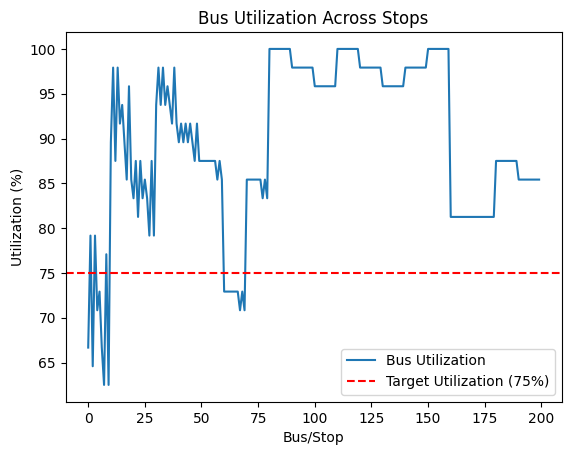

In [247]:
# Step 4: Visualization (Optional)
# Plotting the utilization of buses across the route
plt.plot(bus_utilization, label="Bus Utilization")
plt.axhline(y=75, color='r', linestyle='--', label="Target Utilization (75%)")
plt.title("Bus Utilization Across Stops")
plt.xlabel("Bus/Stop")
plt.ylabel("Utilization (%)")
plt.legend()
plt.show()